# Проект для «Викишоп» с применением BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**
Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<a id='К-содержанию'></a>
**Содержание проекта** \
[Подготовка и анализ данных](#Подготовка-и-анализ-данных)\
[Обучение](#Обучение)\
[Тестирование](#Тестирование)\
[Общие выводы](#Общий-вывод)\
[Чек-лист_проверки](#Чек-лист-проверки)

In [1]:
%%capture

!pip install numpy==1.26.4
!pip install matplotlib==3.8.4
!pip install catboost
!pip install imbalanced-learn
!pip install torch
!pip install transformers
#!pip install tokenizers==0.10.1

In [2]:
#импортируем библиотеки перед началом проекта одним блоком
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
from tqdm.notebook import tqdm

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# импортируем классы GridSearchCV
from sklearn.model_selection import GridSearchCV
from tqdm import notebook

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import ParameterGrid

# загружаем функции для подготовки текстовых данных
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.metrics import f1_score

# загружаем библиотеки для BERT и Pytorch
import torch
import transformers 
from transformers import DistilBertConfig, DistilBertModel, DistilBertTokenizer
from transformers import BertTokenizer, BertForSequenceClassification

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
# функции для лемматизаци и исключения ненужных символов

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemm_list = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    lemm_text = " ".join(lemm_list)
    return lemm_text

def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s\n]', ' ', text)
    text = " ".join(text.split())
    return text

def process_text(text):
    text = clear_text(text)
    text = lemmatize(text)
    return text

<a id='Подготовка-и-анализ-данных'></a> 
## Подготовка и анализ данных
[К содержанию](#К-содержанию) 

In [4]:
# импортируем данные
pth1 = '/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_13_Wikishop/toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    tweets = pd.read_csv(pth1)
elif os.path.exists(pth2):
    tweets = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [5]:
# посмотрим загруженные данные
tweets.info()
display(tweets.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
# уберем столбец дублирующий индекс
tweets = tweets.drop('Unnamed: 0',axis=1)

# приведем все текстовые значения к нижнему регистру
tweets = tweets.apply(lambda col: col.apply(lambda x: x.lower() if isinstance(x, str) else x))

tweets.head()

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0


In [7]:
# проверим дубликаты
print('Количество дубликатов: ', tweets.duplicated().sum())

# уберем дубликаты
tweets = tweets.drop_duplicates()

# проверим значения целевого признака
print('Уникальные значения целевого признака: ', tweets['toxic'].unique())

Количество дубликатов:  45
Уникальные значения целевого признака:  [0 1]


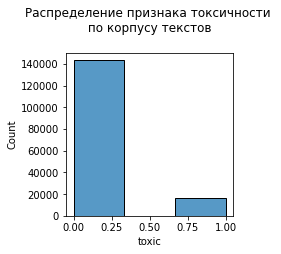

In [8]:
# посмотрим на распределение целевого признака
plt.figure(figsize=(3,3))
sns.histplot(tweets['toxic'], bins=3)
plt.title('Распределение признака токсичности \n по корпусу текстов \n');

In [9]:
RANDOM_STATE = 1

# разделим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    tweets['text'], tweets['toxic'], test_size=0.25, random_state=RANDOM_STATE, stratify = tweets['toxic'])

# проверим размерности до балансировки
print('Размерности до балансировки: \n',
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape)


print(X_train.isna().sum())

Размерности до балансировки: 
 (119435,) (39812,) (119435,) (39812,)
0


In [10]:
print(f'Пример исходного текста тренировочной выборки: \n\n {X_train.iloc[0]} \n')
print('Пример исходного текста тестовой выборки: \n\n', X_test.iloc[0])

Пример исходного текста тренировочной выборки: 

 ":::::if you can't explain yourself and add some substance to your claims that the article is ""screaming pov"", then i suggest you should stop wasting the editors time here.   

" 

Пример исходного текста тестовой выборки: 

 "

 a cheeseburger for you! 

  hi   "


In [11]:
flag1=1
if flag1 == 1:
    
    if os.path.exists('X_train.csv'):
        os.remove('X_train.csv')

    if os.path.exists('X_test.csv'):
        os.remove('X_test.csv')

In [12]:
# скорректируем тексты в корпусе - избавимся от знаков препинания, служебных знаков
# очень долгий процесс, поэтому после первого прогона сохраняем лемматизированные файлы на диск 
# и потом просто их подгружаем

# проверяем, существуют ли файлы
if os.path.exists('X_train.csv') and \
    os.path.exists('X_test.csv') and \
    os.path.exists('y_train.csv') and \
    os.path.exists('y_test.csv'):
    
    # загружаем данные из файлов
    X_train = pd.read_csv('X_train.csv', squeeze=True)
    y_train = pd.read_csv('y_train.csv', squeeze=True)
    
    X_test = pd.read_csv('X_test.csv', squeeze=True)
    y_test = pd.read_csv('y_test.csv', squeeze=True)
    
else:
    # запускаем tqdm для отображения прогресса
    tqdm.pandas()

    # выполняем лемматизацию с отображением прогресса
    X_train = X_train.progress_apply(lambda x: process_text(x))
    X_test = X_test.progress_apply(lambda x: process_text(x))
    
    
    # удалим пустые после лемматизации строки и соответствующие им значения целевого признака
    indices_to_drop_train = X_train[X_train == ''].index
    indices_to_drop_test = X_test[X_test == ''].index

    X_train = X_train.drop(indices_to_drop_train).reset_index(drop=True)
    y_train = y_train.drop(indices_to_drop_train).reset_index(drop=True)

    X_test = X_test.drop(indices_to_drop_test).reset_index(drop=True)
    y_test = y_test.drop(indices_to_drop_test).reset_index(drop=True)
    
    # сохраняем обработанные данные
    X_train.to_csv('X_train.csv', index=False)
    y_train.to_csv('y_train.csv', index=False)
    X_test.to_csv('X_test.csv', index=False)
    y_test.to_csv('y_test.csv', index=False)


  0%|          | 0/119435 [00:00<?, ?it/s]

  0%|          | 0/39812 [00:00<?, ?it/s]

In [13]:
print(f'Пример преобразованного текста тренировочной выборки: \n\n {X_train.iloc[0]} \n')
print('Пример преобразованного текста тестовой выборки: \n\n', X_test.iloc[0])

Пример преобразованного текста тренировочной выборки: 

 if you can t explain yourself and add some substance to your claim that the article be scream pov then i suggest you should stop waste the editor time here 

Пример преобразованного текста тестовой выборки: 

 a cheeseburger for you hi


In [14]:
X_train.isna().sum()

0

In [15]:
# закодируем корпус текстов для обучения модели с помощью TF-IDF
stopwords = list(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words = stopwords) 
X_train_tf_idf = count_tf_idf.fit_transform(X_train)

**Вывод**

По итогу загрузки данных проверили данные на дубликаты и пропуски, корректировка типов не потребовалась, был удален столбец с данными, дублирующими индекс.  
Целевой признак распределен неравномерно, при разделениии на тренировочные и тестовые данные ресемплировали выборки, чтобы соотношение класса '1' стало более значимым - не менее чем 0.5 от класса '0', более сильное выравнивание по классам (занижение записей класса '0' до количества записей класса '1') плохо влияет на обучение модели.  
Далее обработали корпус текстов на предмет занков препинания, служебных символов и стоп-слов, после чего векторизовали весь коопус слов с помощью метода TF-IDF.

<a id='Обучение'></a> 
## Обучение
[К содержанию](#К-содержанию) 

Для обучения были выбраны 3 модели - решающее дерево, логистическая регрессия и ансамбль деревьев CatBoost с несколькими гиперпараметрами:

In [16]:
# создаём итоговый пайплайн с выбором модели и гиперпараметров
pipe_final = Pipeline([
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# задаем наборы гиперпараметров для перебора
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [5,10],
        'models__max_features': [5,10,15]
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__max_iter': [1000],
        'models__C': range(15,17, 21),
        'models__penalty':['l2'],
        'models__class_weight':['balanced',None]
        
    },
    
    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostClassifier(silent=True, random_state=RANDOM_STATE)],
        'models__depth': [6],
        'models__iterations': [25],
        'models__learning_rate': [0.1]
    }
    
]

In [17]:
%time
flag = 1 # флажок для пропуска этой части кода

if flag == 1:
    
    # полный перебор гиперпараметров с помощью GridSearchCV с применением tqdm

    param_grid = ParameterGrid(param_grid)  # параметры для перебора внутри tqdm

    # настройка tqdm
    total_combinations = len(param_grid)
    with tqdm(total=total_combinations) as pbar:
        best_score = -float('inf')
        best_params = None
        best_model = None


        for params in param_grid:
            grid_search = GridSearchCV(
                pipe_final,
                {k: [v] for k, v in params.items()},  # подставляем конкретный набор параметров
                cv=5,
                scoring='f1',
                n_jobs=-1,
            )
            model = grid_search.fit(X_train_tf_idf, y_train)

            # Обновление лучшей метрики
            if model.best_score_ > best_score:
                best_score = model.best_score_
                best_params = params
                best_model = model

            pbar.update(1)  # обновляем прогресс бар tqdm

    # выгружаем лучшую метрику f1 и параметры модели
    print(f'Лучшая метрика F1_score: {best_score}')
    print(f'Параметры лучшей модели: {best_params}')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


  0%|          | 0/9 [00:00<?, ?it/s]

Лучшая метрика F1_score: 0.7673621031391635
Параметры лучшей модели: {'models': LogisticRegression(random_state=1), 'models__C': 15, 'models__class_weight': None, 'models__max_iter': 1000, 'models__penalty': 'l2'}


In [18]:
# указанная метрика получилась при стандартном значении порога 0.5, 
# посмотрим как будет меняться значение метрики при изменении порога

if flag == 1:
    proba = best_model.best_estimator_.predict_proba(X_train_tf_idf)

    probas = pd.DataFrame({
        'predict_proba_0': proba[:, 0],
        'predict_proba_1': proba[:, 1],
        'y_true': y_train.reset_index(drop=True)
    })

    probas.head(3)

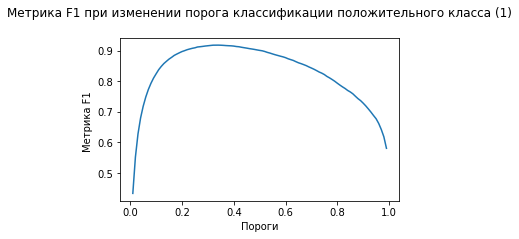

In [19]:
if flag == 1:
    
    thresholds_values = np.arange(0.01, 1.0, 0.01) # сформируем список порогов
    f1_scores = []

    for threshold in thresholds_values:
        y_pred = (probas['predict_proba_1'] >= threshold).astype(int)
        f1_s = f1_score(probas['y_true'], y_pred)
        f1_scores.append(f1_s)

    plt.figure(figsize=(5,3))
    sns.lineplot(x=thresholds_values, y=f1_scores)
    plt.xlabel('Пороги')
    plt.ylabel('Метрика F1 ')
    plt.title('Метрика F1 при изменении порога классификации положительного класса (1)\n')
    plt.show()

In [20]:
if flag == 1:
    print('Максимальное значение метрики F1: ',np.max(f1_scores))
    print('Порог, при котором достигается максимальное значение метрики F1: ', thresholds_values[np.argmax(f1_scores)])

Максимальное значение метрики F1:  0.9176692809920749
Порог, при котором достигается максимальное значение метрики F1:  0.34


Из неспециализированных моделей лучшую метрику на тренировочной выборке показала простая логистическая регрессия со значением метрики F1 - 0.77, при стандартномзначении порога классификации 0.5. При этом максимальное значение метрики достигается при пороге 0.34 (F1 - 0.92), но это скорее всего уже будет переобучением модели.

Посмотрим, какие результаты покажет тот же набор моделей, но с учетом подготовки данных в эмбеддинги с помощью специализированной модель BERT:  
- учитывая ограничения по ресурсам и времени - для теста моделей с использованием BERT выберем 1000 строк из исходного датасета,
- очистим этом корпус текстов,
- закодируем его с помощью BERT в эмбеддинги,
- прогоним через тот же пайплайн моделей, 
- оценим результаты,
- для тестирования возьмем 400 текстов из исходной тестовой выборки.

In [21]:
# подготовим данные для обучения с помощью BERT

# соберем в датафрейм оба признака
sample_bert = pd.DataFrame({'text': X_train})
sample_bert['toxic'] = y_train

# определим размер поднабора
sample_size = 1000

# разделим данные на поднабор данных и остальную часть, сохраняя баланс классов
tweets_sample, _ = train_test_split(sample_bert, 
                                    test_size=len(sample_bert) - sample_size, 
                                    stratify=sample_bert['toxic'], 
                                    random_state=RANDOM_STATE)

tweets_sample = tweets_sample.reset_index(drop=True)
print(tweets_sample.shape)


(1000, 2)


In [22]:
# загрузка предобученного токенизатора

# DistilBertTokenizer
#tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# BERT-toxic
tokenizer = BertTokenizer.from_pretrained('unitary/toxic-bert')

tokenized = tweets_sample['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)
)

max_len = 512  # Используем максимальную длину 512
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])


attention_mask = np.where(padded != 0, 1, 0)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/811 [00:00<?, ?B/s]

In [23]:
# загрузим конфигурационный файл
#config_bert = DistilBertConfig.from_pretrained('distilbert-base-uncased')

# загрузим модель DistilBertModel, как более легкую
#model_bert = DistilBertModel.from_pretrained('distilbert-base-uncased', config=config_bert)

#загружаем BERT-toxic, конфигурацонный файл ненужен для нее, используется стандартный
model_bert = BertForSequenceClassification.from_pretrained("unitary/toxic-bert")

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [24]:
# ранее указанный в уроках алгоритм дообучения BERT немного усовершенствовал 
# для сохранения полученных эмбеддингов на диск, чтобы не превышать допустимый объем памяти
# после прогона обучения - для прогноза загружаем их снова с диска

batch_size = 10
max_length = 512
embedding_dim = model_bert.config.hidden_size  # указываем размерность эмбеддингов

# создаем массив на диске с помощью np.memmap
embeddings_memmap = np.memmap('embeddings.npy', dtype='float32', mode='w+', shape=(padded.shape[0], embedding_dim))

for i in tqdm(range(padded.shape[0] // batch_size), desc="Processing batches") :
    batch = torch.LongTensor(padded[batch_size * i : batch_size * (i + 1), :max_length])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i : batch_size * (i + 1), :max_length])
    
    with torch.no_grad():
        #batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch) #DistilBertModel
        outputs = model_bert(batch, attention_mask=attention_mask_batch, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        # берем средение значения эмбеддингов за последние 4 слоя           
        batch_embeddings = torch.mean(torch.stack(hidden_states[-4:]), dim=0)
        
    # записываем эмбеддинги батча в файл
    #embeddings_memmap[batch_size * i : batch_size * (i + 1), :] = batch_embeddings[0][:, 0, :].cpu().numpy() #DistilBertModel
    embeddings_memmap[batch_size * i : batch_size * (i + 1), :] = batch_embeddings[:, 0, :].cpu().numpy()

    del batch_embeddings  # удаляем временные переменные, чтобы освободить память
    torch.cuda.empty_cache()  # и очищаем память

# синхронизируем данные на диск
embeddings_memmap.flush()
del embeddings_memmap  # закрываем файл

Processing batches:   0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
# загружаем эмбеддинги из файла и разбиваем на количество исходных текстов в корпусе
embeddings_memmap = np.memmap('embeddings.npy', dtype='float32', mode='r')
features = embeddings_memmap.reshape((padded.shape[0], -1))

features

memmap([[-0.6192379 , -1.3221471 , -0.5063638 , ..., -0.37349528,
          0.4302929 ,  0.04284727],
        [-0.6878131 , -1.5087209 ,  0.24257326, ..., -0.3602581 ,
          0.58777344,  0.8803367 ],
        [-0.54722023, -0.79059374, -0.27587694, ..., -0.24656689,
          0.11589866, -0.0401797 ],
        ...,
        [-0.6149867 , -1.4320469 ,  0.26751742, ..., -0.5729021 ,
          0.27687138, -0.1101369 ],
        [-0.9576085 , -0.8323131 , -0.3656378 , ..., -0.5172838 ,
          0.16725567,  1.0194391 ],
        [-0.8237953 , -1.266231  ,  0.32817477, ..., -0.5487284 ,
          0.44511035, -0.05851274]], dtype=float32)

In [26]:
# проверим размерности эмбеддингов и целевого признака
print('Размерность корпуса эмбеддингов: ',features.shape)
print('Размерность целевого признака: ',tweets_sample['toxic'].shape)

Размерность корпуса эмбеддингов:  (1000, 768)
Размерность целевого признака:  (1000,)


In [27]:
# создаём итоговый пайплайнд для перебора того же набора моделей, но на эмбеддингах
pipe_final = Pipeline([
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# задаем наборы гиперпараметрво для перебора
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [5,10],
        'models__max_features': [5,10,15]
    },

    # словарь для модели LinearRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__max_iter': [2000],
        'models__C': range(5,20),
        'models__penalty':['l2'],
        'models__class_weight':['balanced',None]
    },
    
    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostClassifier(silent=True, random_state=RANDOM_STATE)],
        'models__depth': [6,11],
        'models__iterations': [25,50],
        'models__learning_rate': [0.1]
    }
    
]

In [28]:
# для удобства переименуем корпус данных на эмбеддингах на тренировочный и тестовый
X_train_b = features
y_train_b = tweets_sample['toxic']

In [29]:
%time

# полный перебор гиперпараметров с помощью GridSearchCV
param_grid = ParameterGrid(param_grid)  # параметры для перебора внутри tqdm

# настройка tqdm
total_combinations = len(param_grid)
with tqdm(total=total_combinations) as pbar:
    best_score_b = -float('inf')
    best_params_b = None
    best_model_b = None

    
    for params in param_grid:
        grid_search = GridSearchCV(
            pipe_final,
            {k: [v] for k, v in params.items()},  # подставляем конкретный набор параметров
            cv=5,
            scoring='f1',
            n_jobs=-1,
        )
        model_b = grid_search.fit(X_train_b, y_train_b)
        
        # Обновление лучшей метрики
        if model_b.best_score_ > best_score_b:
            best_score_b = model_b.best_score_
            best_params_b = params
            best_model_b = model_b
        
        pbar.update(1)  # обновляем прогресс бар tqdm

# выгружаем лучшую метрику f1 и параметры модели
print(f'Лучшая метрика F1_score: {best_score_b}')
print(f'Параметры лучшей модели: {best_params_b}')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs


  0%|          | 0/40 [00:00<?, ?it/s]

Лучшая метрика F1_score: 0.9109772637969193
Параметры лучшей модели: {'models': <catboost.core.CatBoostClassifier object at 0x7f949a21a5e0>, 'models__depth': 6, 'models__iterations': 50, 'models__learning_rate': 0.1}


**Вывод**

Из неспециализированных моделей (DecisionTreeClassifier, LogisticRegression, CatBoost) лучшую метрику на тренировочной выборке на данных, закодированных с помощью метода TF-IDF, показала простая логистическая регрессия со значением метрики F1 - 0.77 при стандартном значении порога классификации 0.5. 
Применив тот же пайплайн моделей, но на данных закодированных в эмбеддинги с помощью Bert-Toxic при использовании для обучения 1000 текстов из всего корпуса, лучший результат снова у логистической регрессии с метрикой F1 - 0.91. То есть обучение c на сильно меньшей выборке, но с применением более совершенной модели (подготовки токенов и эмбеддингов) показало большую эффективность.

<a id='Тестирование'></a> 
## Тестирование
[К содержанию](#К-содержанию) 

Проведем тестирование моделей по итогам обучения, при этом т.к. обучение на эмбеддингах с использованием BERT проводилось на гораздо меньшем корпусе текстов, тестирование на одном и том же объеме тестовой выборки затруднительно, поэтому проведем два теста - для моделей на данных, веторизированных с помощью TF-IDF на всем корпусе тестового набора данных, а модели обученнные с помощью BERT-toxic на случайном поднаборе из 400 текстов тестового набора.

In [30]:
# проверим лучшую модель на тестовых данных (TF-IDF) 

if flag == 1: # флажок для пропуска раздела
    
    X_test_tf_idf = count_tf_idf.transform(X_test)

    y_pred = best_model.predict(X_test_tf_idf)

    # считаем метрику на тестовых данных
    f1_test = f1_score(y_test, y_pred)
    print(f'Метрика f1 на тестовых данных при векторизации TF-IDF: {f1_test:.3f}')

Метрика f1 на тестовых данных при векторизации TF-IDF: 0.776


In [31]:
# проверим лучшую модель на тестовых данных (BERT) 
# выберем 400 текстов из тестовых данных

y_test = y_test.reset_index(drop=True)

# соберем в датафрейм оба признака
tweets_test = pd.DataFrame({'text': X_test})
tweets_test['toxic'] = y_test

print(tweets_test.head(10))

# определим размер поднабора
test_sample_size = 400

# разделим данные на поднабор данных и остальную часть, сохраняя баланс классов
tweets_test_sample, _ = train_test_split(tweets_test, 
                                    test_size=len(tweets_test) - test_sample_size, 
                                    stratify=tweets_test['toxic'], 
                                    random_state=RANDOM_STATE)

tweets_test_sample = tweets_test_sample.reset_index(drop=True)
print(tweets_test_sample.shape)

                                                text  toxic
0                          a cheeseburger for you hi      0
1  no it s or shell a differ a bit on how many be...      0
2  unblock reason the user that report me make se...      0
3  a wp consensus say in determine consensus cons...      0
4  and let be frank it not a if you give a toss a...      1
5  deep web article thanks for your message i mak...      0
6  avenue road the article be make into a redirec...      0
7                               fine then i hate you      1
8  i don t understand why wouldn t analysis of gr...      0
9  test card f music ceefax music isn t the same ...      0
(400, 2)


In [32]:
# токенизируем тестовые данные
tokenized_test = tweets_test_sample['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

max_len = 512
padded_test = np.array([i + [0]*(max_len - len(i)) for i in tokenized_test.values])

attention_mask = np.where(padded_test != 0, 1, 0)

In [33]:
# готовим эмбеддинги на тестовых данных
batch_size = 10
max_length = 512
embedding_dim = model_bert.config.hidden_size  # указываем размерность эмбеддингов

# создаем массив на диске с помощью np.memmap
embeddings_memmap_test = np.memmap('embeddings_test.npy', 
                                   dtype='float32', 
                                   mode='w+', 
                                   shape=(padded_test.shape[0], 
                                   embedding_dim))

for i in tqdm(range(padded_test.shape[0] // batch_size), desc="Processing batches") :
    batch = torch.LongTensor(padded_test[batch_size * i : batch_size * (i + 1), :max_length])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i : batch_size * (i + 1), :max_length])
    
    with torch.no_grad():
        #batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)
        outputs = model_bert(batch, attention_mask=attention_mask_batch, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        #batch_embeddings = hidden_states[-1]  # Последний слой скрытых состояний           
        batch_embeddings = torch.mean(torch.stack(hidden_states[-4:]), dim=0)
    
    # записываем эмбеддинги батча в файл
    #embeddings_memmap_test[batch_size * i : batch_size * (i + 1), :] = batch_embeddings[0][:, 0, :].cpu().numpy()
    embeddings_memmap_test[batch_size * i : batch_size * (i + 1), :] = batch_embeddings[:, 0, :].cpu().numpy()
    del batch_embeddings  # удаляем временные переменные, чтобы освободить память
    torch.cuda.empty_cache()  # и очищаем память

# синхронизируем данные на диск
embeddings_memmap_test.flush()
del embeddings_memmap_test  # закрываем файл

Processing batches:   0%|          | 0/40 [00:00<?, ?it/s]

In [34]:
# загружаем эмбеддинги из файла и разбиваем на количество исходных текстов в корпусе
embeddings_memmap_test = np.memmap('embeddings_test.npy', dtype='float32', mode='r')
features_test = embeddings_memmap_test.reshape((padded_test.shape[0], -1))

features_test

memmap([[ 4.66242164e-01,  5.44436216e-01, -8.28052044e-01, ...,
         -8.77397835e-01, -1.95933893e-01, -5.73798537e-01],
        [-7.21752644e-01, -1.32724118e+00,  2.81873167e-01, ...,
         -6.46222353e-01,  4.15188730e-01, -9.19613987e-04],
        [-1.21839952e+00, -1.23614597e+00, -6.61065727e-02, ...,
         -6.67648494e-01,  4.22346473e-01,  3.34278971e-01],
        ...,
        [-8.54678512e-01, -1.30826712e+00,  2.02274859e-01, ...,
         -7.89361715e-01,  2.25308716e-01,  2.39377812e-01],
        [-1.06655371e+00, -1.09008610e+00,  1.84332788e-01, ...,
         -4.16305423e-01,  4.04093117e-01,  1.56281292e-01],
        [-8.73986483e-01, -1.50817966e+00,  2.50843614e-02, ...,
         -5.33541322e-01,  5.11457145e-01,  1.07865304e-01]],
       dtype=float32)

In [35]:
# также проверим лучшую модель на тестовой части выборки на эмбеддингах
y_pred_b_test = best_model_b.predict(features_test)

# считаем метрику на тестовых данных
f1_test_b = f1_score(tweets_test_sample['toxic'], y_pred_b_test)
print(f'Метрика f1 на тестовых данных при векторизации с помощью BERT: {f1_test_b:.3f}')

Метрика f1 на тестовых данных при векторизации с помощью BERT: 0.895


**Вывод**

На тестах модель LogisticRegression обученная на данных, закодированных с помощью TF-IDF, но на всем корпусе тестовых данных показала лучшую метрику F1 - 0.776, а модель Catboost, обученная на эмбеддингах  показала 0.895, то есть оба вариант обучения превысили требуемый порог 0.75.


<a id='Общие-выводы'></a> 
## Общие выводы
[К содержанию](#К-содержанию) 

По итогу **загрузки данных** проверили данные на дубликаты и пропуски, корректировка типов не потребовалась, был удален столбец с данными, дублирующими индекс.
Целевой признак распределен неравномерно, при разделениии на тренировочные и тестовые данные ресемплировали выборки, чтобы соотношение класса '1' стало более значимым - не менее чем 0.5 от класса '0', более сильное выравнивание по классам (занижение записей класса '0' до количества записей класса '1') плохо влияет на обучение модели.
Далее обработали корпус текстов на предмет знаков препинания, служебных символов и стоп-слов, после чего векторизовали весь корпус слов с помощью метода TF-IDF.
Для **обучения** были выбраны 3 алгоритма - решающее дерево, логистическая регрессия и ансамбль деревьев CatBoost, которые были применены к ранее подготовленному корпусу текстов. Из неспециализированных моделей лучшую метрику на тренировочной выборке показала простая логистическая регрессия со значением метрики F1 - 0.776, при стандартном значении порога классификации 0.5. 
Далее было принято решение попробовать обучить тот же пайплайн алгоритмов, но на наборе эмбеддингов подготовленных с помощью **модели BERT-toxic**. С учетом затратности и по ресурсам и времени для подготовки эмбеддингов и обучения была выбрана подвыборка из 1000 текстов, при обучении на которой лучший результат также показала логистическая регрессия с метрикой F1 - 0.91, что даже лучше модели обученной на большем количестве данных.

Учитывая результаты обучения, явным лидером с значительно более высокой метрикой стала модель, обученная CatBoost на малом корпусе текстов(1000 шт.), при этом обе модели превысили требуемвй порог качества(0.75), поэтому было принято решение осуществить тестирование обоих вариантов.  

При **тестировании**, **модель, обученная на всем корпусе текстов,** показала результат по метрике **F1 - 0.776**, что соответствует условиям задачи. **Модель, обученная на эмбеддингах** показала намного более сильную метрику **F1 - 0.895**, подтвердив, свою прогнозную способность по сравнению с более простым вариантом.

Соответственно для целей использования в работе рекомендована **модель, обученная на эмбеддингах**, то есть более подходящая модель кодирования текстовых данных, предобученная на подходящем дл классификации корпуске текстов BERT-toxic, значительно лучше справляется с поставленной задачей.


<a id='Чек-лист-проверки'></a> 
## Чек-лист проверки
[К содержанию](#К-содержанию) 

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны